# Problem Set #5: Development

In [255]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import os

## 1) Get everything set up

In [256]:
# path to kinetic mechanism
fname_mech = os.path.abspath('..') + '\\mechanisms\\stanford-mech_v12.cti'
fname_mech

'C:\\Users\\asusa\\pycharm_projects\\me362b_winter2021\\mechanisms\\stanford-mech_v12.cti'

In [257]:
# create the solution instance
sln = ct.Solution(fname_mech)
sln()


  gas:

       temperature             300  K
          pressure          101325  Pa
           density       0.0818891  kg/m^3
  mean mol. weight         2.01588  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy           26470        5.336e+04     J
   internal energy     -1.2109e+06       -2.441e+06     J
           entropy           64914        1.309e+05     J/K
    Gibbs function     -1.9448e+07        -3.92e+07     J
 heat capacity c_p           14312        2.885e+04     J/K
 heat capacity c_v           10187        2.054e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2              1                1         -15.7173
     [   +9 minor]              0                0



In [258]:
species = sln.species_names
species

['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'N2', 'AR']

In [259]:
rxns = sln.reaction_equations()
rxns

['H + O2 <=> O + OH',
 'H + O2 (+M) <=> HO2 (+M)',
 'H + O2 (+AR) <=> HO2 (+AR)',
 'H + O2 (+O2) <=> HO2 (+O2)',
 'H + O2 (+H2O) <=> HO2 (+H2O)',
 'H2O2 (+M) <=> 2 OH (+M)',
 'H2O2 + OH <=> H2O + HO2',
 'H2O2 + OH <=> H2O + HO2',
 'HO2 + OH <=> H2O + O2',
 '2 HO2 <=> H2O2 + O2',
 '2 HO2 <=> H2O2 + O2',
 'H2O + M <=> H + OH + M',
 '2 H2O <=> H + H2O + OH',
 '2 OH <=> H2O + O',
 'H2 + O <=> H + OH',
 'H2 + O <=> H + OH',
 'H2 + OH <=> H + H2O',
 'H + HO2 <=> 2 OH',
 'H + HO2 <=> H2O + O',
 'H + HO2 <=> H2 + O2',
 'HO2 + O <=> O2 + OH',
 'H + H2O2 <=> H2 + HO2',
 'H + H2O2 <=> H2O + OH',
 'H2O2 + O <=> HO2 + OH',
 'H2 + M <=> 2 H + M',
 '2 H2 <=> 2 H + H2',
 'H2 + N2 <=> 2 H + N2',
 'H2 + O2 <=> 2 H + O2',
 '2 O + M <=> O2 + M',
 'AR + 2 O <=> AR + O2',
 'H + O + M <=> OH + M']

In [260]:
# set up the conditions
oxidizer = {'AR': .99, 'O2':.01}
fuel = {'H2':1.}
P0 = 101325.

In [261]:
def reset_sln(sln, T, P=P0, phi=1.):
    sln.TP = T, P
    sln.set_equivalence_ratio(phi=phi, oxidizer=oxidizer, fuel=fuel)

reset_sln(sln, 1200)
sln()


  gas:

       temperature            1200  K
          pressure          101325  Pa
           density        0.397347  kg/m^3
  mean mol. weight         39.1263  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      4.8591e+05        1.901e+07     J
   internal energy      2.3091e+05        9.035e+06     J
           entropy          4737.3        1.854e+05     J/K
    Gibbs function     -5.1988e+06       -2.034e+08     J
 heat capacity c_p           540.1        2.113e+04     J/K
 heat capacity c_v           327.6        1.282e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2      0.0196078       0.00101024         -21.9093
                O2     0.00980392       0.00801798          -31.712
                AR       0.970588         0.990972         -20.2422
     [   +7 minor]          

In [262]:
# set up the reactor and network
r1 = ct.ConstPressureReactor(contents=sln, energy='on')
r1

In [263]:
rnet = ct.ReactorNet(reactors=(r1,))
rnet

In [264]:
def reset_reactor(sln,  T, rnet=rnet, P=P0, phi=1.):
    reset_sln(sln, T, P=P, phi=phi)
    rnet.set_initial_time(0)

In [265]:
reset_reactor(sln, 1200)

ts, Ts, spcs = [], [], {}
for sp in sln.species_names:
    spcs[sp] = []

In [266]:
def get_state(rnet, ts=ts, Ts=Ts, spcs=spcs):
    ts += [rnet.time]
    Ts += [sln.T]
    sp_dict = sln.mole_fraction_dict()
    for sp in sln.species_names:
        spcs[sp] += [sp_dict.get(sp, 0)]

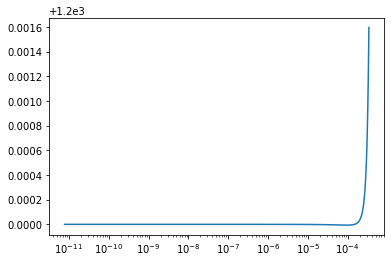

In [267]:
for i in range(100):
    rnet.step()
    get_state(rnet)

plt.semilogx(ts, Ts)

(1e-05, 0.1)

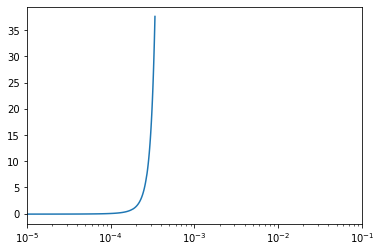

In [268]:
plt.semilogx(ts[:-1], np.diff(Ts) / np.diff(ts))
plt.xlim((1e-5, 1e-1))

(0.0001, 0.1)

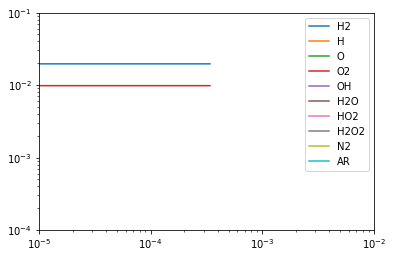

In [269]:
# for sp in ['O2', 'H2', 'OH', 'H']:
for sp in sln.species_names:
    plt.loglog(ts, spcs[sp], label=sp)
plt.legend()
plt.xlim((1e-5, 1e-2))
plt.ylim((1e-4, 1e-1))

In [270]:
t_ign = {}
for sp in ['O', 'OH', 'H']:
    t_ign[sp] = ts[np.argmax(spcs[sp])]

dT_dt = np.diff(Ts) / np.diff(ts)
t_ign['T'] = ts[:-1][np.argmax(dT_dt)]

t_ign

{'O': 0.00034122510046749187,
 'OH': 0.00034122510046749187,
 'H': 0.00034122510046749187,
 'T': 0.0003383405406374369}

In [271]:
reset_reactor(sln, 1200)
sln.equilibrate('HP')
T_eq = sln.T
T_eq

1431.6925915038444

In [295]:
def calc_T_ign_stop(sln, fractional_rise=0.95) -> float:
    """
    calculates the temperature at which to stop an ignition delay simulation
    :param sln: ct.Solution at initial simulation conditions
    :return T_stop: float, stopping temperature
    """

    TPX_0 = sln.TPX

    # get the equilibrium temperature of the solution to use as a stop condition
    sln.equilibrate('HP')
    Teq = sln.T

    # calculate the temperature at which to stop the simulation
    T_stop = TPX_0[0] + fractional_rise * (Teq - TPX_0[0])

    sln.TPX = TPX_0

    return T_stop

def add_state_to_dict(sln, rnet, result_dict):
    result_dict['time'] += [rnet.time]
    result_dict['T'] += [sln.T]
    for sp, x in zip(sln.species_names, sln.X):
        result_dict[sp] += [x]

def ignition_delay_dY_dt(res_dict, Y_key):
    ts = res_dict['time']
    ts_mean = ts[:-1] + np.diff(ts) / 2

    Ys = res_dict[Y_key]
    dY_dt = np.diff(Ys) / np.diff(ts)

    return ts_mean[np.argmax(dY_dt)]

def ignition_delay_maxY(res_dict, Y_key):
    ts = res_dict['time']
    return ts[np.argmax(res_dict[Y_key])]

def calculate_ignition_delays(res_dict):
    ign_delays = {'T':ignition_delay_dY_dt(res_dict, 'T'),
                  'H2O':ignition_delay_dY_dt(res_dict, 'H2O'),
                  'OH':ignition_delay_maxY(res_dict, 'OH'),
                  'O':ignition_delay_maxY(res_dict, 'O'),
                  'H':ignition_delay_maxY(res_dict, 'H')}
    return ign_delays

def run_ignition_simulation(sln, T_stop=None, verbose=False):
    """

    :param sln:
    :return:
    """
    if T_stop is None:  # get the stop condition
        T_stop = calc_T_ign_stop(sln)

    # set up the reactor and network
    r1 = ct.ConstPressureReactor(sln)
    rnet = ct.ReactorNet((r1, ))

    # set up dictionary of lists to store time-series results
    result_dict = {'time':[], 'T':[]}
    for sp in sln.species_names:
        result_dict[sp] = []

    while sln.T < T_stop:
        rnet.step()
        add_state_to_dict(sln, rnet, result_dict)

    if verbose:
        print(f'Number of simulation steps = {len(result_dict["time"])}')
        print(f'Reactor end time = {result_dict["time"][-1]*1e3:4.2f} ms')

    return result_dict

In [296]:
# %%timeit

reset_sln(sln, 1000)
result_dict = run_ignition_simulation(sln)
ign_delay = calculate_ignition_delays(result_dict)
print(ign_delay)

{'T': 0.0030990908528359014, 'H2O': 0.0030076669772036084, 'OH': 0.0035327603441262347, 'O': 0.003196701675437886, 'H': 0.0032462084161688307}


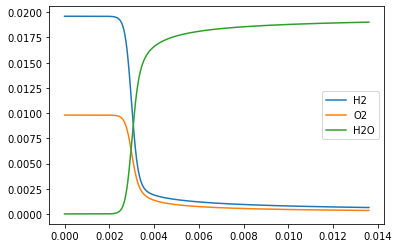

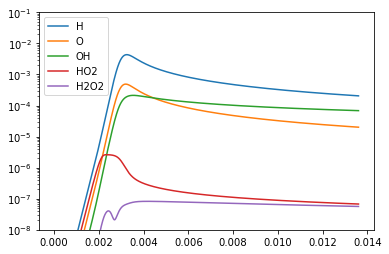

In [297]:
plt.figure()
for sp in sln.species_names:
    if sp in ['H2', 'O2', 'H2O']:
        plt.plot(result_dict['time'], result_dict[sp], label=sp)
plt.legend()

plt.figure()
for sp in sln.species_names:
    if sp not in ['AR', 'H2', 'O2', 'H2O', 'N2']:
        plt.semilogy(result_dict['time'], result_dict[sp], label=sp)

plt.ylim((1e-8, 1e-1))
plt.legend()

In [298]:
T0s = np.arange(1000, 2001, 100)
ign_delays = {}

for T0 in T0s:
    reset_sln(sln, T0)
    result_dict = run_ignition_simulation(sln)
    ign_delays[T0] = calculate_ignition_delays(result_dict)

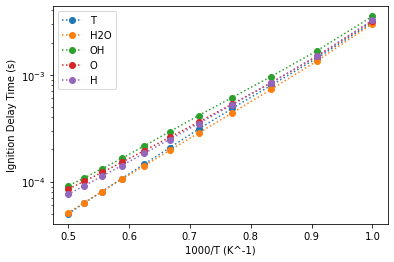

In [315]:
ign_delay_by_type = {}
for method in ign_delays[T0s[0]].keys():
    ign_delay_by_type[method] = []
    for T0 in ign_delays.keys():
        ign_delay_by_type[method] += [ign_delays[T0][method]]

    plt.semilogy(1000/T0s, np.array(ign_delay_by_type[method]), 'o:', label=method)

plt.legend()
plt.xlabel('1000/T (K^-1)')
plt.ylabel('Ignition Delay Time (s)');

## Sensitivity